<a href="https://colab.research.google.com/github/affandhanbad-dev/ML_Model_Training_notebook/blob/main/Garbage_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Dataset extraction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import cv2
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import zipfile
import matplotlib.image as mpimg

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download mostafaabla/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/mostafaabla/garbage-classification
License(s): ODbL-1.0
garbage-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
with zipfile.ZipFile('/content/garbage-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [5]:
!ls

garbage_classification	garbage-classification.zip  kaggle.json  sample_data


# Data Processing

In [6]:
cardboard = os.listdir("/content/garbage_classification/cardboard")
len(cardboard)

891

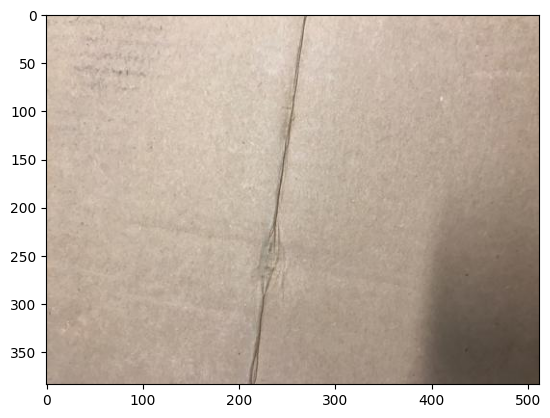

In [7]:
image = mpimg.imread("/content/garbage_classification/cardboard/cardboard221.jpg")
plt.imshow(image)

In [8]:
clothes = os.listdir("/content/garbage_classification/clothes")
len(clothes)

5325

In [9]:
paths = []
classes = ['battery','biological','brown-glass','cardboard','clothes','green-glass',
           'metal','paper','plastic','shoes','trash','white-glass']
for cls in classes:
    folder_path = "/content/garbage_classification/" + cls
    paths.append(folder_path)
    images = os.listdir(folder_path)
    print(cls, ":", len(images))

battery : 945
biological : 985
brown-glass : 607
cardboard : 891
clothes : 5325
green-glass : 629
metal : 769
paper : 1050
plastic : 865
shoes : 1977
trash : 697
white-glass : 775


In [10]:
paths

['/content/garbage_classification/battery',
 '/content/garbage_classification/biological',
 '/content/garbage_classification/brown-glass',
 '/content/garbage_classification/cardboard',
 '/content/garbage_classification/clothes',
 '/content/garbage_classification/green-glass',
 '/content/garbage_classification/metal',
 '/content/garbage_classification/paper',
 '/content/garbage_classification/plastic',
 '/content/garbage_classification/shoes',
 '/content/garbage_classification/trash',
 '/content/garbage_classification/white-glass']

In [11]:
data = []
labels = []
for path in paths:
    label = path.split('/')[-1]  # folder name as label

    for image_name in os.listdir(path):
        img_path = os.path.join(path, image_name)

        try:
            img = Image.open(img_path).resize((64,64)).convert('RGB')
            img = np.array(img)

            data.append(img)
            labels.append(label)

        except Exception as e:
            print(f"Error loading image: {img_path}")

In [12]:
data = np.asarray(data)
labels = np.asarray(labels)

In [56]:
labels

array(['battery', 'battery', 'battery', ..., 'white-glass', 'white-glass',
       'white-glass'], dtype='<U11')

Balancing the Dataset

In [13]:
!pip install imblearn

In [14]:
from imblearn.under_sampling import RandomUnderSampler
import numpy as npm

In [15]:
data.shape,labels.shape

((15515, 64, 64, 3), (15515,))

In [16]:
nsample, nx, ny, nz = data.shape
data_2d = data.reshape((nsample,nx*ny*nz))

In [17]:
rus = RandomUnderSampler(random_state=42)

In [18]:
data_res, labels_res = rus.fit_resample(data_2d, labels)

In [19]:
data_res = data_res.reshape((-1, nx, ny, nz))
print(data_res.shape)
print(labels_res.shape)

(7284, 64, 64, 3)
(7284,)


In [20]:
X = data
Y = labels

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
type(Y_train)

numpy.ndarray

In [23]:
Y_train.shape

(12412,)

In [24]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [25]:
X_train_scaled.shape

(12412, 64, 64, 3)

# Model

In [26]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64,64,3))
for layer in base_model.layers:
    layer.trainable = False


In [35]:
model = Sequential (
    [
     base_model,
     Flatten(), # Add Flatten layer here
     Dense(256, activation='relu'),
     Dropout(0.5),
     Dense(128, activation='relu'),
     Dropout(0.5),
     Dense(12, activation='softmax')
    ]
)

In [36]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)


In [60]:
label_encoder.classes_

array(['battery', 'biological', 'brown-glass', 'cardboard', 'clothes',
       'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash',
       'white-glass'], dtype='<U11')

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1
)

train_generator = train_datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(64,64),
    batch_size=8,       # smaller batch reduces memory
    class_mode='sparse', # integer labels
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/garbage_classification',
    target_size=(64,64),
    batch_size=8,
    class_mode='sparse',
    subset='validation'
)


Found 13970 images belonging to 12 classes.
Found 1545 images belonging to 12 classes.


In [46]:
hisotry = model.fit(X_train_scaled, Y_train_encoded, validation_split=0.1, epochs=5, batch_size=4)

Epoch 1/5
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - accuracy: 0.3942 - loss: 1.9376 - val_accuracy: 0.4452 - val_loss: 1.7267
Epoch 2/5
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.4049 - loss: 1.8821 - val_accuracy: 0.4469 - val_loss: 1.7302
Epoch 3/5
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - accuracy: 0.3980 - loss: 1.8926 - val_accuracy: 0.4485 - val_loss: 1.7187
Epoch 4/5
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.4051 - loss: 1.8798 - val_accuracy: 0.4614 - val_loss: 1.7816
Epoch 5/5
2793/2793 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.4084 - loss: 1.8476 - val_accuracy: 0.4517 - val_loss: 1.7378


# Result

In [47]:
loss , accuracy = model.evaluate(X_test_scaled,Y_test_encoded)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4357 - loss: 1.7765


In [48]:
loss

1.7635602951049805

In [49]:
accuracy

0.4415082037448883

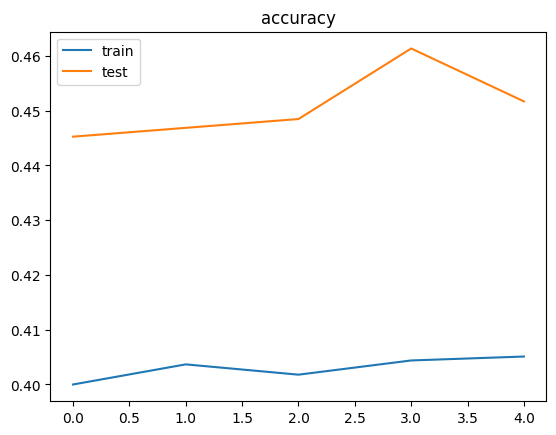

In [53]:
plt.title('accuracy')
plt.plot(hisotry.history['accuracy'], label='train')
plt.plot(hisotry.history['val_accuracy'], label='test')
plt.legend()

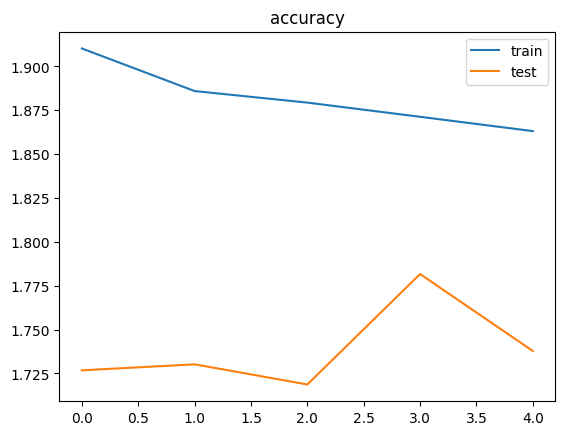

In [54]:
plt.title('accuracy')
plt.plot(hisotry.history['loss'], label='train')
plt.plot(hisotry.history['val_loss'], label='test')
plt.legend()

# Input

In [62]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resized = cv2.resize(input_image, (64,64))

input_image_scaled = input_image_resized/255

input_image_reshaped = np.reshape(input_image_scaled, [1,64,64,3])

input_prediction = model.predict(input_image_reshaped)

print(input_prediction)